# new data processing notebook 2023

## Goals:
- tidy up
- resolve issues with different framerates (bin every thing to 10 hz? also easier to compute)
- move all pipeline to local
- define functions for extracting meta-data (from excel sheet)
- define functions for determining genotypes (mouse id matches)
- apply reverse & and pop-out method to leave the loop < 4 layers
    - use if != statement with returns so the process is stopped
    - move the same calculation with a separate def fuction outside the loop
    - also for 2 conditional statements, try to combine this in 1 if statement to prevent nesting
    - 
- consider if using nap is better for handling time series
- save files
    - consider what to save (npy/z files with what structures?)


#### make sure you're using pynapple environment

In [1]:
## import packages

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import seaborn as sns
import os
import glob
import datetime
import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint
from tqdm import tqdm
import dabest
import sys
from BaselineRemoval import BaselineRemoval
import pynapple as nap
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('/Users/hunglo/Documents/python_codes/')
import binge

In [2]:
## plotting settings

## create color map
my_color_map = ['#56b4e9',
                '#e69f00',
                '#009e73',
                '#f0e442',
                '#0072b2',
                '#d55e00',
                '#cc79a7']

my_color_map = sns.color_palette(my_color_map)

def get_auto_colors(n_colors):
    auto_color_map_cat = sns.color_palette("husl", n_colors)
    return auto_color_map_cat

def correct_baseline_modploy(df_accepted):
    input_array = df_accepted.values
    polynomial_degree=2 #only needed for Modpoly and IModPoly algorithm
    baseObj=BaselineRemoval(input_array)
    Modpoly_output=baseObj.ModPoly(polynomial_degree)
    df_corrected = pd.DataFrame(data=Modpoly_output,index=df_accepted.index,columns=[' C1'])
    return df_corrected

def load_mouse_info_from_meta_data():
  import pandas as pd
  import numpy as np
  filename = '/Users/hunglo/Documents/inscopix_csv/Recordings_overview.csv'
  # url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTPyLFWYecnKapIC0TWEH5w_VZVyJYsDVCt0rfG73266Dm4XWtf7IwuIBbTV3TcYVABa8UEkcCMqDza/pub?gid=143829771&single=true&output=csv"
  df_overview = pd.read_csv(filename,skiprows=2)
  df_overview = df_overview[df_overview['Imaging?']==True] ## Only load those sessions with recordings.
  mouse_id_list = df_overview['Mouse ID'].unique()
  mouse_id_list = mouse_id_list[~pd.isnull(mouse_id_list)]
  mouse_id_list = sorted(mouse_id_list)
  return df_overview, mouse_id_list

df_overview, mouse_id_list = load_mouse_info_from_meta_data()
# df_overview.info()



In [3]:
### function block, need to move to "binge.py" later, but will keep them here

def norm_ca(df):
    df_norm = pd.DataFrame([])
    for idx,cell in enumerate(df.columns):
        ## normalize to 0-1
        df_max=np.max(df[cell])
        df_min=np.min(df[cell])
        df_norm[cell] = (df[cell]-df_min)/(df_max-df_min)
    return df_norm

def ca2_plot(df,scale=5,cell_idx=None,**kwargs):
    ## scale here is just to help viz
    if cell_idx == None:
        for idx,cell in enumerate(df.columns):
            plt.plot(df[cell]*scale+idx,lw=1,**kwargs)
    else:
        for idx,cell_ in enumerate(list(cell_idx)):
            ## normalize to 0-1
            cell = df.columns[idx]
            plt.plot(df[cell]*scale+idx,lw=1,**kwargs)


def detect_binge_bout(Pump1,interval=3):
    # if pump interval is less than 2 seconds?
    Pump1 = np.pad(Pump1, (2, 2), 'constant', constant_values=(0,0))
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[idx_+1])
        end_concat.append(Pump1[idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending
    binge_epoch = nap.IntervalSet(start_concat,end_concat)
    return binge_epoch


## downsample Ca2+ data to 10 Hz all together for easier processing afterward?
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num],columns=df_accepted.columns)
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted


def get_PETH_dict(df_accepted,slow_milk_ts_clean):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {} 

    cellset = df_accepted.columns
    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        for trial, time in enumerate(slow_milk_ts_clean):
            value = df_accepted[cell][time-half_window:time+half_window].values

            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_milk[cell] = PETH_trace
    return PETH_trace_milk


def get_PETH_binge(df_accepted,binge_epoch):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_binge_on = {} 
    PETH_trace_binge_off = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['start']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_on[cell] = PETH_trace

        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['end']):
            value = df_accepted[cell][time-half_window:time+half_window].values
            while len(value)<100:
                print(trial,time)
                print('add nan to last part')
                value = np.pad(value, (0, 1), 'constant', constant_values=(np.nan,np.nan))
            else:
                PETH_trace[trial,:] = value[0:num_bins] # keep the slicer here so in case we got one more value here
        PETH_trace_binge_off[cell] = PETH_trace
    return PETH_trace_binge_on,PETH_trace_binge_off

## align baseline to 0
def baseline_correct(PETH):
    for key in PETH.keys():
        matrix = PETH.get(key)
        for trial in range(matrix.shape[0]):
            matrix[trial,:] -= np.mean(matrix[trial,40:50]) # baseline mean centered (1 sec before event time)
        PETH[key] = matrix
    return PETH

In [4]:
### note i remove all the BES0424 from processing now, 
### having issue on 0424, dat: 21.05.11. since it's so few cells probably not
### worth to fix it
### the issue: no lick after a pump event, resulting a complete 

In [ ]:
## load inscopix & phenosys data

Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
extension = 'csv'
os.chdir(Phenosys_folder)
result = sorted(glob.glob('*.{}'.format(extension)))

result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
# result = [r for r in result if 'DSC018624' in r or 'DSC018623' in r]
# result = [r for r in result if 'DSC016028' in r or 'DSC019409' in r]
# result = [r for r in result if 'BES0424' in r]
# result = [r for r in result if 'DSC012019' in r]
# result = [r for r in result if 'DSC012972' in r]

# print(result)

for file_path in tqdm(result[:]):
  file_path = os.path.join(Phenosys_folder,file_path)
  mouse_id = file_path.split('_Inscopix-')[0].split('/')[-1]
  date     = file_path.split('_Inscopix-')[1].split('_')[0]
  print(mouse_id,date)
  L1,P1,P2,PAll = binge.load_phenosys(file_path)
  L1 = np.pad(L1, (0, 1), 'constant', constant_values=(np.nan,3000)) ## add a very far lick event to prevent a conditional error later
  L1_,P1_,P2_,PAll_ = binge.load_phenosys_nofilter(file_path)

  if False:
    binge.pheno_eventplot(P1,P2,PAll,P1_,P2_,PAll_,L1,mouse_id,date)
    binge.pheno_lick_eventplot(L1,L1_,PAll,mouse_id,date)
    df_GPIO = binge.load_GPIO_csv(file_path)
    GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init=binge.extract_GPIO_trace(df_GPIO,plot=True)
    binge.pheno_eventplot(P1,P2,PAll,GPIO_pump1_clean, GPIO_pump2_clean, GPIO_pump_all_no_init,L1,mouse_id,date)

  ## make a condition here to check if we have the corresponding Ca2+
  df_accepted, df_z = binge.loadandsync_incopix_csv(file_path)

  interval = 3
  binge_epoch = detect_binge_bout(PAll,interval=interval)
  # now get remaining period as non binge period
  if len(PAll)==0:
    print(f'There isnt a feeding event in this {mouse_id}_{date} recording, pass!')
    print('=======================================================')

    continue # skip this one
  not_binge_epoch = nap.IntervalSet(0,PAll[-1]+50).set_diff(binge_epoch)  
  not_binge_epoch['start'] = not_binge_epoch['start']+0.2 # to exclude boundary events
  not_binge_epoch['end']   = not_binge_epoch['end']-0.2   # to exclude boundary events

  slow_milk_ts  = nap.Ts(P1).restrict(not_binge_epoch).index # get all other events as slow
  slow_water_ts = nap.Ts(P2).restrict(not_binge_epoch).index

  # check there is licking after the delivery in 2 sec
  # print([t for t in slow_milk_ts  if (L1[L1>t][0]-t) <2])

  slow_milk_ts_clean  = np.array([t for t in slow_milk_ts  if (L1[L1>t][0]-t) <2])
  slow_water_ts_clean = np.array([t for t in slow_water_ts if (L1[L1>t][0]-t) <2])

  df_downsampled   = downsample(df_accepted)
  df_downsampled_z = downsample(df_z)

  # if there is no slow eating event
  if len(slow_milk_ts_clean)==0:
     PETH_trace_milk = {}
  else:
     PETH_trace_milk = get_PETH_dict(df_downsampled_z,slow_milk_ts_clean)
     PETH_trace_milk  = baseline_correct(PETH_trace_milk)
  if len(slow_water_ts_clean)==0:
      PETH_trace_water = {}
  else:
      PETH_trace_water = get_PETH_dict(df_downsampled_z,slow_water_ts_clean)
      PETH_trace_water = baseline_correct(PETH_trace_water)

  if binge_epoch.shape[0] == 0:
      PETH_trace_binge_on,PETH_trace_binge_off = {},{}
  else:
      PETH_trace_binge_on,PETH_trace_binge_off = get_PETH_binge(df_downsampled_z,binge_epoch)
      PETH_trace_binge_on  = baseline_correct(PETH_trace_binge_on)
      PETH_trace_binge_off = baseline_correct(PETH_trace_binge_off)


  select_overview = df_overview[df_overview['Mouse ID'] == mouse_id].copy()
  select_overview = select_overview[select_overview['Recording date']=='20'+date]

  Pump1_solution = select_overview['Flavor 1'].to_numpy()[0].lower()
  Pump2_solution = select_overview['Flavor 2'].to_numpy()[0].lower()
  Food_deprivation = select_overview['Food_deprived'].to_numpy()[0].lower()
  if 'CaMK2a' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'CaMK2'
  elif 'iSeroSnFR' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'iSeroSnFR'
  elif 'dLight' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'dLight'
  elif 'S2GC' in select_overview['Genotype'].to_numpy()[0]:
      Genotype = 'S2GC'
  elif 'S2' in select_overview['Genotype'].to_numpy()[0]:
      Genotype = 'S2'
  elif 'GC' in select_overview['Genotype'].to_numpy()[0]:
      Genotype = 'GC'
  else:
    Genotype = select_overview['Genotype'].to_numpy()[0]
  mouse_name = select_overview['Mouse Name'].to_numpy()[0]

  ## initiate a dict for saving npy
  dat = {}
  dat['PETH_binge_on']   = PETH_trace_binge_on
  dat['PETH_binge_off']  = PETH_trace_binge_off
  dat['PETH_slow_milk']  = PETH_trace_milk
  dat['PETH_slow_water'] = PETH_trace_water
  dat['Binge_epoch']     = binge_epoch

  dat['mouse_name']    = mouse_name
  dat['mouse_id']      = mouse_id
  dat['cell_type']     = Genotype
  dat['date_exp']      = date.replace(".", "") # save with no dot, so it's YYMMDD
  dat['pump_solution'] = (Pump1_solution, Pump2_solution)
  dat['dt']            = 0.10 # second, exposure time of each frame
  dat['food_deprivation_level'] = Food_deprivation

  output_file_name = f'/Users/hunglo/Documents/inscopix_csv/processed_npy/{mouse_id}_{date}_{Genotype}_{Pump1_solution}_{Pump2_solution}_{Food_deprivation}.npy'
  np.save(output_file_name, dat)
  print(f'saved: {mouse_id} {date.replace(".", "")}')

print('All done!')  



In [5]:
## check npy files
file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
# result = [r for r in result if 'DSC018623' in r]
result = [r for r in result if 'BES0233' in r]

# print(result)
file_path = os.path.join(file_folder,result[2]) # 623: 4,6,9 ok

dat = np.load(file_path, allow_pickle=True)
dat.item().keys()

def load_npy(file_path):
    dat = np.load(file_path, allow_pickle=True)
# dat.item().keys()
    # print(dat.item().get('date_exp'))
    PETH_binge_on   = dict2np(dat.item().get('PETH_binge_on',"Empty!"))
    PETH_binge_off  = dict2np(dat.item().get('PETH_binge_off',"Empty!"))
    PETH_slow_milk  = dict2np(dat.item().get('PETH_slow_milk',"Empty!"))
    PETH_slow_water = dict2np(dat.item().get('PETH_slow_water',"Empty!"))
    return PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water

def dict2np(PETH):

    keys = list(PETH.keys())

    if len(keys) == 0:
        return None
    else:
        dat_temp = PETH.get(keys[0])
        PETH_new = np.zeros((len(keys),dat_temp.shape[0],dat_temp.shape[1]))
        for idx,cell in enumerate(keys):
            PETH_new[idx,:,:] = PETH[cell]
        return PETH_new

PETH_binge_on, PETH_binge_off, PETH_slow_milk, PETH_slow_water = load_npy(file_path=file_path)

## now perform auROC here?

# keys = list(PETH_binge_on.keys())

# for i in range(5):
#     traces = PETH_binge_on[i]
#     # print(PETH_binge_on.get(key).mean(axis=0))
#     plt.plot(traces.mean(axis=0)+traces.shape[0],color='k')
#     # plt.show()
#     # plt.imshow(PETH_binge_on.get(key), aspect='auto')
#     ca2_plot(df=pd.DataFrame(traces).T,scale=1,cell_idx=None,ls='--')
#     plt.axvline(x=50,color='k',ls=':',lw=1)
#     sns.despine()
#     plt.show()


In [79]:
def cal_auroc(PETH, baseline_window=1,steps=50):
  """
  PETH: 3D np array of neuronal matrix, ordered with neurons, trials, timestamps
  baseline_window: * sec before pump delivery, default is 1 sec

  """
  from sklearn.metrics import auc

  auc_total_all_cell       = np.zeros((PETH.shape[0],PETH.shape[2]))
  frate = 10 # all 10 Hz

  data = PETH
  for idx in range(data.shape[0]):
        if idx%50==0:
          print(f'now at neuron: {idx}')
        
        baseline = data[idx,:,50-baseline_window*frate:50].flatten()
        auc_total = []
        for i in range(data.shape[2]):
          stimulus = data[idx,:,i]
          pool = [*baseline, *stimulus]
          steps = steps
          criteria = [min(pool) + (j*(max(pool)-min(pool))/steps) for j in range(steps)]
          criteria[0] = criteria[0] - 1e-12 # modify the min value to slighter lesser value, so baseline/stimulus will be larger than the min of criteria
          pbase = []
          pstim = []
          # Calculate P(above threshold) for each cutoff
          for cri in criteria:
            pbase.append(sum(baseline > cri)/len(baseline))
            pstim.append(sum(stimulus > cri)/len(stimulus))
          auc_ = auc(x = pbase, y = pstim)
          auc_total.append(auc_)
        auc_total_all_cell[idx,:] = auc_total

  return auc_total_all_cell

# auroc = cal_auroc(PETH_slow_milk, baseline_window=5)
# auroc

In [7]:
## make a classification function here based on auROC
def checkConsecutive(l,n=3):
    n = n-1 # diff will be one less than all elements in the list
    return (sum(np.diff(sorted(l)) == 1) >= n) 

def cell_class(auroc,window=2,threshold_sd=3.5):
   idx_positive = []
   frate = 10
   for idx in range(auroc.shape[0]):
    threshold_high = np.mean(auroc[idx,0:10]) + np.std(auroc[idx,0:10])*threshold_sd
    auroc_temp = auroc[idx].copy()

    j_temp = []
    data_temp = []

    for j in range(50,50+window*frate):  # Only look at first 2 sec after delivery (the window size)
        if auroc_temp[j] > threshold_high:
           j_temp.append(j)
    if j_temp !=[]:
        if checkConsecutive(j_temp,n=4) == True:
           idx_positive.append(idx)
      # print('# {} is responding to milk'.format(idx))
   return idx_positive

# idx_positive = cell_class(auroc,window=2,threshold_sd=3.5)
# print(idx_positive)

# print(f'{round(len(idx_positive)/auroc.shape[0]*100,2)}')


In [8]:
def cal_cohensd(mouse_id,window_size=None,processed_npy_path=None):
    print(mouse_id)
    if processed_npy_path is None:
        processed_npy_path = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa mice
    result = [r for r in result if mouse_id in r]

    if window_size is None:
        window_size=[1,4] # from +-1 sec to onset, to +-4 sec to onset

    estimation_list = []
    date_list = []
    triton_list = []
    fasting_list = []
    milk_consumption_list = []
    window_size_list_inloop = []

    triton_mouse_list = ['BES0421','DSC016028','DSC019409']

    if mouse_id in triton_mouse_list:
        triton_dates = ['211006','211007','211008','211009','211011',
                        '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                        '221102','221103','221104','221105']
    else:
        triton_dates = []

    for i in result[:]:
        datenodot = i.split('_')[1].replace('.','')
        print(datenodot)

        file_path = os.path.join(file_folder,i)
        PETH_binge_on, _,_,_ = load_npy(file_path=file_path) # note date will be print from here
        if PETH_binge_on is None:
            print('no binges, skip')
            continue
        else:
            print(PETH_binge_on.shape)
            if PETH_binge_on.shape[0]<3: # too few cells
                print('too few cells, skip')
                continue
            else:
                date_list.append(datenodot)
                if datenodot in triton_dates:
                    triton_list.append(True)
                else:
                    triton_list.append(False)
                if 'severe' in i:
                    fasting_list.append(True)
                else:
                    fasting_list.append(False)

                ## convert np array to pd.DataFrame
                df_binge_auc = pd.DataFrame([np.trapz(PETH_binge_on[:,:,50-window_size[1]*10:50-window_size[0]*10].mean(axis=(1)),dx=0.1),
                                             np.trapz(PETH_binge_on[:,:,50+window_size[0]*10:50+window_size[1]*10].mean(axis=(1)),dx=0.1),])
                df_binge_auc = df_binge_auc.T
                                            #  columns=['Pre-binge-on','Post-binge-on'])
                df_binge_auc.rename(columns={0:'Pre-binge-on',1:'Post-binge-on'},inplace=True)
                df_binge_auc = df_binge_auc.reset_index()
                df_binge_auc.rename(columns={'index':'ID'},inplace=True)
                df_binge_auc

                ## Save estimation object in dict
                estimation_dict = {}
                two_groups_paired = dabest.load(df_binge_auc, idx=("Pre-binge-on","Post-binge-on"),paired=True, id_col="ID")
                estimate = two_groups_paired.cohens_d.results

                estimation_dict[i] = estimate
                estimation_list.append(estimate['difference'].to_numpy()[0])
                # print(f'>AUC cohens_d: {estimation_list[-1]:.2f}')
                Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
                extension = 'csv'
                os.chdir(Phenosys_folder)
                result_pheno = sorted(glob.glob('*.{}'.format(extension)))
                result_pheno = [r for r in result_pheno if mouse_id in r]
                result_pheno = [r for r in result_pheno if i.split('_')[1] in r]
                # print(result_pheno)
                # result_pheno
                file_path_pheno = os.path.join(Phenosys_folder,result_pheno[0])
                L1,P1,P2,PAll = binge.load_phenosys(file_path_pheno)
                milk_consumption = len(PAll)
                # print(milk_consumption)
                milk_consumption_list.append(milk_consumption)
                window_size_str = f'{window_size[0]}_{window_size[1]}'
                window_size_list_inloop.append(window_size_str)           

    df_estimate = pd.DataFrame([date_list,estimation_list]).T
    df_estimate.rename(columns={0:'date',1:'cohens_d'}, inplace=True)
    df_estimate['cohens_d'] = df_estimate['cohens_d'].astype('float')
    df_estimate['mouse_id'] = mouse_id
    df_estimate['anosmic'] = triton_list
    df_estimate['fasted'] = fasting_list
    df_estimate['milk_consumption'] = milk_consumption_list
    df_estimate['window_size'] = window_size_list_inloop

    return df_estimate

mouse_id = 'DSC017911'
window_size_list = [[0,4],
                    [1,4],
                    [2,4],
                    [0,3],
                    [1,3],
                    [0,2],
                    [0,1]]

df_estimate_concat = pd.DataFrame([])
for window_size in window_size_list:
    df_estimate = cal_cohensd(mouse_id,window_size=window_size,processed_npy_path=None)
    df_estimate_concat = pd.concat([df_estimate_concat,df_estimate])

df_estimate_concat

DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)
DSC017911
220815
(131, 9, 100)
220816
(128, 11, 100)


,date,cohens_d,mouse_id,anosmic,fasted,milk_consumption,window_size
0,220815,-0.140964,DSC017911,False,False,194,0_4
1,220816,-0.093138,DSC017911,False,False,176,0_4
0,220815,-0.136341,DSC017911,False,False,194,1_4
1,220816,-0.137687,DSC017911,False,False,176,1_4
0,220815,-0.182606,DSC017911,False,False,194,2_4
1,220816,-0.177152,DSC017911,False,False,176,2_4
0,220815,-0.120364,DSC017911,False,False,194,0_3
1,220816,-0.039613,DSC017911,False,False,176,0_3
0,220815,-0.112300,DSC017911,False,False,194,1_3
1,220816,-0.092545,DSC017911,False,False,176,1_3


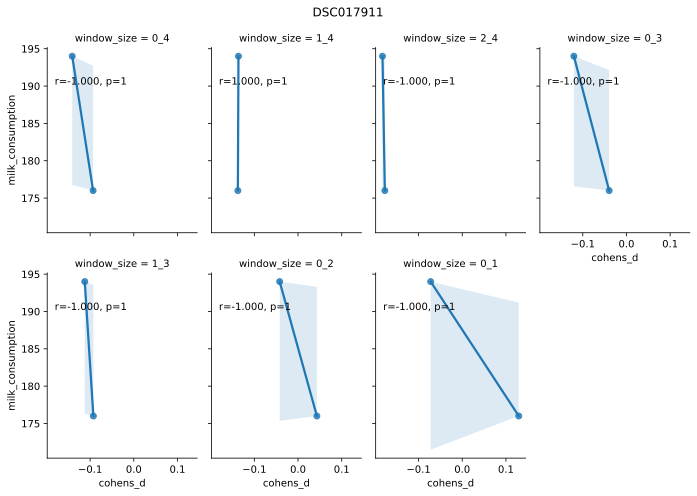

In [9]:
## viz for checking the results

import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['cohens_d'], data['milk_consumption'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.3f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
data = df_estimate_concat[df_estimate_concat['fasted'] == False]
g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='window_size',height=3.5,aspect=0.7,col_wrap=4)
g.map_dataframe(annotate)
g.fig.subplots_adjust(top=.9)
g.fig.suptitle(mouse_id)
plt.show()


In [ ]:
df_estimate_concat = pd.DataFrame([])

# result = [r for r in result if 'DSC018623' in r]

camk2_mouse_id_list = ['BES0224','BES0225','BES0233','BES0421','BES0424','BES0427','DSC016028','DSC019409']
gc_mouse_id_list = ['DSC018623','DSC018624','DSC017911']
pv_mouse_id_list = ['DSC012019','DSC012487','DSC016006']
sst_mouse_id_list = ['DSC012972','DSC013919','DSC014459' ]

window_size_list = [[0,4],
                    [1,4],
                    [2,4],
                    [0,3],
                    [1,3],
                    [0,2],
                    [0,1]]

Celltype = 'gc'
# Celltype = 'apc_camk2'
# Celltype = 'apc_sst'
# Celltype = 'apc_pv'

df_estimate_concat = pd.DataFrame([])

# for mouse_id in camk2_mouse_id_list:
for mouse_id in gc_mouse_id_list:
# for mouse_id in pv_mouse_id_list:
# for mouse_id in sst_mouse_id_list:
    for window_size in window_size_list:
        df_estimate = cal_cohensd(mouse_id=mouse_id,window_size=window_size)
        df_estimate['Celltype'] = Celltype
        df_estimate_concat = pd.concat([df_estimate_concat,df_estimate])

df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/{Celltype}_cohensd_window.csv',index=False)
print('\nDone')


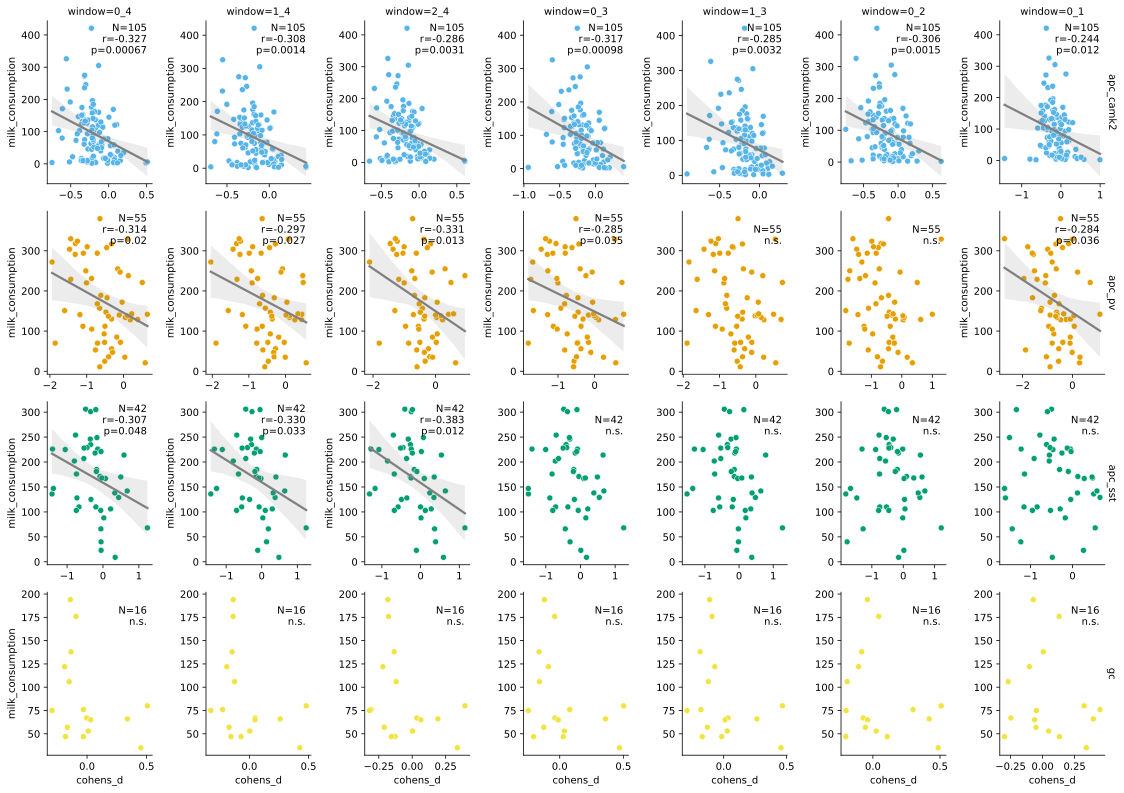

In [10]:

file_list = ['apc_camk2_cohensd_window.csv',
             'apc_pv_cohensd_window.csv',
             'apc_sst_cohensd_window.csv',
             'gc_cohensd_window.csv',]

df_estimate_concat = pd.DataFrame([])

for file in file_list:
    file_path = os.path.join('/Users/hunglo/Documents/inscopix_csv/processed_csv/',file)
    df_estimate = pd.read_csv(file_path)
    df_estimate_concat = pd.concat([df_estimate_concat,df_estimate])


# Celltype = 'apc_camk2'


import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['cohens_d'], data['milk_consumption'])
    n = len(data)
    ax = plt.gca()
    if p <0.05:
        ax.text(.95, .8, f'N={n}\nr={r:.3f}\np={p:.2g}',ha='right',
                transform=ax.transAxes)
        sns.regplot(data=data,x='cohens_d',y='milk_consumption',ax=ax,scatter=False,color='grey')
        # ax.set_axis(off)
        x_axis = ax.axes.get_xaxis()
        x_label = x_axis.get_label()
        x_label.set_visible(False)
    else:
        ax.text(.95, .8, f'N={n}\nn.s.',transform=ax.transAxes,ha='right')

data = df_estimate_concat[df_estimate_concat['fasted'] == False]
data = data[data['anosmic']==False]

g = sns.FacetGrid(data=data,row='Celltype',col='window_size',margin_titles=True,hue='Celltype', sharex=False, sharey=False,palette=my_color_map,height=3,aspect=0.75)
# g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='window_size',height=4,aspect=0.75,row='Celltype', sharex=False, sharey=False,hue='Celltype')
g.map_dataframe(sns.scatterplot, x='cohens_d',y='milk_consumption')
# g.map_dataframe(sns.regplot, x='cohens_d',y='milk_consumption')
g.map_dataframe(annotate)
g.set_titles(col_template="window={col_name}", row_template="{row_name}")
g.fig.subplots_adjust(top=.9)
# g.fig.suptitle(Celltype)
plt.show()

In [11]:
data = df_estimate_concat[df_estimate_concat['fasted'] == False]
data

,date,cohens_d,mouse_id,anosmic,fasted,milk_consumption,window_size,Celltype
0,200818,-0.212930,BES0224,False,False,196,0_4,apc_camk2
1,200820,-0.285028,BES0224,False,False,126,0_4,apc_camk2
2,200821,-0.175879,BES0224,False,False,111,0_4,apc_camk2
3,200824,0.120512,BES0224,False,False,39,0_4,apc_camk2
4,200825,-0.148341,BES0224,False,False,131,0_4,apc_camk2
...,...,...,...,...,...,...,...,...
149,220816,-0.092545,DSC017911,False,False,176,1_3,gc
150,220815,-0.041997,DSC017911,False,False,194,0_2,gc
151,220816,0.043149,DSC017911,False,False,176,0_2,gc
152,220815,-0.072270,DSC017911,False,False,194,0_1,gc


(105, 8)
(36, 9)
(35, 9)
(34, 9)
-0.2554978560907169
-0.10138393701040926
   group1  group2      Diff     Lower     Upper   q-value   p-value
0     top  middle  0.114626  0.000121  0.229131  3.367329  0.049697
1     top  bottom  0.158680  0.026043  0.291316  4.024250  0.014691
2  middle  bottom  0.044054 -0.071891  0.159999  1.278079  0.628187


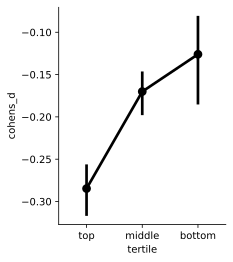

In [34]:
## tertile data by milk consumption
## only get data without anosmic & fasting
data = df_estimate_concat[df_estimate_concat['fasted'] == False]
data = data[data['anosmic']==False]
data = data[data['window_size']=='0_4']
data = data[data['Celltype']=='apc_camk2']

print(data.shape)
data['milk_rank_pct'] = data['milk_consumption'].rank(pct=True)
top_data = data[data['milk_rank_pct']>0.67]
bottom_data = data[data['milk_rank_pct']<0.34]
middle_data = data[np.logical_and(data['milk_rank_pct']<0.67,data['milk_rank_pct']>0.34)]
print(top_data.shape)
print(bottom_data.shape)
print(middle_data.shape)

print(top_data['cohens_d'].mean())
print(bottom_data['cohens_d'].mean())

## make a new column labeled as "top","middle","bottom"

tertile_list = []
for pct in data['milk_rank_pct']:
    # if pct > 0.67:
    if pct > 0.75:
        tertile_list.append('top')
    # elif pct < 0.34:
    elif pct < 0.25:
        tertile_list.append('bottom')
    else:
        tertile_list.append('middle')

data['tertile'] = tertile_list
data

plt.figure(figsize=[3,4])
# sns.catplot(data=data,x='tertile',y='cohens_d',kind='box')
# sns.stripplot(data=data,x='tertile',y='cohens_d',dodge=1,alpha=0.4)
sns.pointplot(data=data,x='tertile',y='cohens_d',color='k',ci=68)
sns.despine()

# data = top_data
# g = sns.FacetGrid(data=data,row='Celltype',col='window_size',margin_titles=True,hue='Celltype', sharex=False, sharey=False,palette=my_color_map,height=3,aspect=0.75)
# g.map_dataframe(sns.scatterplot, x='cohens_d',y='milk_consumption')
# g.map_dataframe(annotate)
# g.set_titles(col_template="window={col_name}", row_template="{row_name}")
# g.fig.subplots_adjust(top=.9)
# plt.show()

# data = bottom_data
# g = sns.FacetGrid(data=data,row='Celltype',col='window_size',margin_titles=True,hue='Celltype', sharex=False, sharey=False,palette=my_color_map,height=3,aspect=0.75)
# g.map_dataframe(sns.scatterplot, x='cohens_d',y='milk_consumption')
# g.map_dataframe(annotate)
# g.set_titles(col_template="window={col_name}", row_template="{row_name}")
# g.fig.subplots_adjust(top=.9)
# plt.show()
from scipy import stats
stats.f_oneway(data[data['tertile']=='top']['cohens_d'].values, data[data['tertile']=='middle']['cohens_d'].values,data[data['tertile']=='bottom']['cohens_d'].values)
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('cohens_d ~ C(tertile)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=data, res_var='cohens_d', xfac_var='tertile', anova_model='cohens_d ~ C(tertile)')
print(res.tukey_summary)

## qqplot
# sm.qqplot(res.anova_std_residuals, line='45')
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Standardized Residuals")
# plt.show()

(3990, 100)
(7300, 100)
(2166, 100)


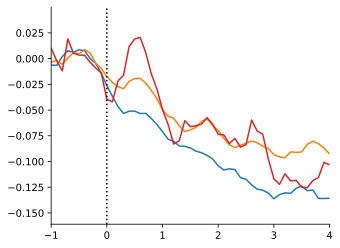

(-1.0, 4.0)

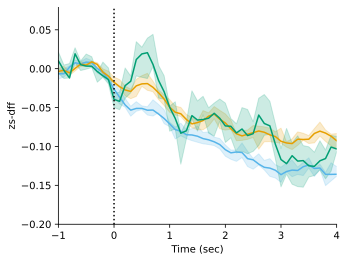

In [35]:
## now use this to generate PETH data

## load PETH from npy and concat all together
select_data = data[data['tertile']=='top']
mouse_id_list = sorted(select_data['mouse_id'].unique())

def get_npy_path(mouse_id,date):
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if mouse_id in r]
    datewithdot = f'{date[0:2]}.{date[2:4]}.{date[4:6]}'
    result = [r for r in result if datewithdot in r]
    # print(result)
    file_path = os.path.join(file_folder,result[0])
    return file_path

def concat_PETH_binge(select_data,mouse_id_list):
    PETH_binge_on_concat = np.zeros([1,100])
    # print(PETH_binge_on_concat.shape)
    for mouse_id in mouse_id_list:
        # print(mouse_id)
        date_list = select_data[select_data['mouse_id']==mouse_id]['date'].values.astype('str')
        for date in date_list:
            # print(f'>{date}')
            PETH_binge_on,_,_,_ = load_npy(get_npy_path(mouse_id,date))
            PETH_avg = np.mean(PETH_binge_on,axis=1) # trial average
            # print(PETH_avg.shape[0])
            PETH_binge_on_concat = np.vstack([PETH_binge_on_concat,PETH_avg])
    # print(PETH_binge_on_concat.shape)
    PETH_binge_on_concat = PETH_binge_on_concat[~np.all(PETH_binge_on_concat == 0, axis=1)] # remove first row
    print(PETH_binge_on_concat.shape)
    return PETH_binge_on_concat

def concat_PETH_slow_milk(select_data,mouse_id_list):
    PETH_binge_on_concat = np.zeros([1,100])
    # print(PETH_binge_on_concat.shape)
    for mouse_id in mouse_id_list:
        # print(mouse_id)
        date_list = select_data[select_data['mouse_id']==mouse_id]['date'].values.astype('str')
        for date in date_list:
            # print(f'>{date}')
            PETH_binge_on,_,_,_ = load_npy(get_npy_path(mouse_id,date))
            PETH_avg = np.mean(PETH_binge_on,axis=1) # trial average
            # print(PETH_avg.shape[0])
            PETH_binge_on_concat = np.vstack([PETH_binge_on_concat,PETH_avg])
    # print(PETH_binge_on_concat.shape)
    PETH_binge_on_concat = PETH_binge_on_concat[~np.all(PETH_binge_on_concat == 0, axis=1)] # remove first row
    print(PETH_binge_on_concat.shape)
    return PETH_binge_on_concat

## load PETH top
select_data = data[data['tertile']=='top']
mouse_id_list = sorted(select_data['mouse_id'].unique())
PETH_binge_on_concat_top = concat_PETH_binge(select_data,mouse_id_list)

## load PETH middle
select_data = data[data['tertile']=='middle']
mouse_id_list = sorted(select_data['mouse_id'].unique())
PETH_binge_on_concat_middle = concat_PETH_binge(select_data,mouse_id_list)

## load PETH bottom
select_data = data[data['tertile']=='bottom']
mouse_id_list = sorted(select_data['mouse_id'].unique())
PETH_binge_on_concat_bottom = concat_PETH_binge(select_data,mouse_id_list)

t_scale = np.arange(-5,5,0.1)
plt.figure(figsize=[5,4])
plt.plot(t_scale,PETH_binge_on_concat_top.mean(axis=0))
plt.plot(t_scale,PETH_binge_on_concat_middle.mean(axis=0))
plt.plot(t_scale,PETH_binge_on_concat_bottom.mean(axis=0),c='C3')
plt.axvline(x=0,ls=':',c='k')
sns.despine()
plt.xlim(xmin=-1,xmax=4)
plt.show()


def np2df_long(PETH_binge_on_concat,tertile=None):
    df_ = pd.DataFrame(PETH_binge_on_concat)
    df_long = pd.melt(df_.reset_index(),id_vars='index',value_name='zs-dff',var_name='Time (sec)')
    df_long['Time (sec)']=(df_long['Time (sec)'].values/10)-5
    df_long['tertile'] = tertile
    return df_long

df_PETH_binge_on_concat_top = np2df_long(PETH_binge_on_concat_top,tertile='top')
df_PETH_binge_on_concat_middle = np2df_long(PETH_binge_on_concat_middle,tertile='middle')
df_PETH_binge_on_concat_bottom = np2df_long(PETH_binge_on_concat_bottom,tertile='bottom')

# df_PETH_binge_on_concat = pd.concat([df_PETH_binge_on_concat_top,df_PETH_binge_on_concat_middle,df_PETH_binge_on_concat_bottom])
# df_PETH_binge_on_concat

fast_plot = True
if fast_plot:
    n_boot = 10
else:
    n_boot = 1000
plt.figure(figsize=[5,4])
sns.lineplot(data=df_PETH_binge_on_concat_top,x='Time (sec)',y='zs-dff',n_boot=n_boot,color=my_color_map[0],ci=68)
sns.lineplot(data=df_PETH_binge_on_concat_middle,x='Time (sec)',y='zs-dff',n_boot=n_boot,color=my_color_map[1],ci=68)
sns.lineplot(data=df_PETH_binge_on_concat_bottom,x='Time (sec)',y='zs-dff',n_boot=n_boot,color=my_color_map[2],ci=68)
plt.axvline(x=0,ls=':',c='k')
sns.despine()
plt.xlim(xmin=-1,xmax=4)
# plt.axis('off')
# plt.show()

In [ ]:
# idx_top = cal_auroc(PETH_binge_on_concat_top)
# idx_middle = cal_auroc(PETH_binge_on_concat_middle)
# idx_bottom = cal_auroc(PETH_binge_on_concat_bottom)

In [80]:
## next steps: pre-calculate auroc and save as npy, so later we just need to repload the file

file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
extension = 'npy'
os.chdir(file_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# result = [r for r in result if mouse_id in r]
result = [r for r in result if 'SNA' not in r] # exclude dopa & sero data

auroc_folder = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/'

fast_cal_auroc = False
if fast_cal_auroc:
    steps = 2
else:
    steps = 20

for r in result[:]:
    print(r)
    auroc = []
    mouse_id = r.split('_')[0]
    date = r.split('_')[1]
    celltype = r.split('_')[2] 
    flavor1 = r.split('_')[3]
    flavor2 = r.split('_')[4]
    file_path = os.path.join(file_folder,r)
    output_name = f'{auroc_folder}auroc_{mouse_id}_{date}_{celltype}_{flavor1}.npy'
    if os.path.isfile(output_name):
        print(f'auroc of {mouse_id} {date} {flavor1} already calculated, skip')
        continue
    else:
        PETH_binge_on,PETH_binge_off,PETH_slow_milk,PETH_slow_water = load_npy(file_path)
        if PETH_slow_milk is None:
            print('slow milk drinking events, skip')
            continue
        auroc = cal_auroc(PETH_slow_milk,steps=steps)
        np.save(output_name,auroc)
        print(f'cal auroc & saved: {mouse_id} {date} {flavor1}')

    output_name = f'{auroc_folder}auroc_{mouse_id}_{date}_{celltype}_{flavor2}.npy'
    if os.path.isfile(output_name):
        print(f'auroc of {mouse_id} {date} {flavor2} already calculated, skip')
        continue
    else:
        if PETH_slow_water is None:
            print('slow water drinking events, skip')
            continue
        auroc = cal_auroc(PETH_slow_water,steps=steps)
        np.save(output_name,auroc)
        print(f'cal auroc & saved: {mouse_id} {date} {flavor2}')


# def get_npy_path(mouse_id,date):
#     file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
#     extension = 'npy'
#     os.chdir(file_folder)
#     result = sorted(glob.glob('*.{}'.format(extension)))
#     result = [r for r in result if mouse_id in r]
#     datewithdot = f'{date[0:2]}.{date[2:4]}.{date[4:6]}'
#     result = [r for r in result if datewithdot in r]
#     # print(result)
#     file_path = os.path.join(file_folder,result[0])
#     return file_path


BES0224_20.08.18_CaMK2_strawberry_water_mild.npy
now at neuron: 0
now at neuron: 50
now at neuron: 100


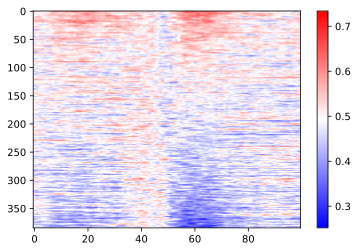

43
11.17%


(40.0, 103.95)

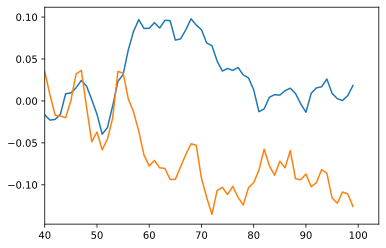

In [78]:
# ## load auroc npy file for viz checking

# file_path = '/Users/hunglo/Documents/inscopix_csv/auroc_npy/auroc_BES0224_20.08.18_CaMK2_strawberry.npy'
# auroc = np.load(file_path, allow_pickle=True)
# auroc.shape

# isort = np.argsort(-auroc[:,50:70].mean(axis=1))
# plt.imshow(auroc[isort],aspect='auto',cmap='bwr')
# plt.colorbar()
# plt.show()

# milk_idx = cell_class(auroc=auroc,window=3)
# print(len(milk_idx))
# print(f'{len(milk_idx)/auroc.shape[0]*100:.2f}%')


# vmin, vmax = -0.5,0.5
# # plt.imshow(PETH_slow_milk[milk_idx,:,:].mean(axis=1),aspect='auto',cmap='seismic',vmin=vmin, vmax=vmax)
# # plt.show()
# # plt.imshow(PETH_binge_on[milk_idx,:,:].mean(axis=1),aspect='auto',cmap='seismic',vmin=vmin, vmax=vmax)
# # plt.show()

# plt.plot(PETH_slow_milk[milk_idx,:,:].mean(axis=(0,1)))
# plt.plot(PETH_binge_on[milk_idx,:,:].mean(axis=(0,1)))
# plt.xlim(xmin=40)

In [18]:
## function for calculate cohen's d on binging for all recordings

df_estimate_concat = pd.DataFrame([])

# result = [r for r in result if 'DSC018623' in r]

camk2_mouse_id_list = ['BES0224','BES0225','BES0233','BES0421','BES0424','BES0427','DSC016028','DSC019409']
gc_mouse_id_list = ['DSC018623','DSC018624','DSC017911']
pv_mouse_id_list = ['DSC012019','DSC012487','DSC016006']
sst_mouse_id_list = ['DSC012972','DSC013919','DSC016066' ]
# for mouse_id in camk2_mouse_id_list:
# for mouse_id in gc_mouse_id_list:
# for mouse_id in pv_mouse_id_list:
for mouse_id in sst_mouse_id_list:
    print(f'\nnow process: {mouse_id}')
    # mouse_id = 'BES0224'
    file_folder = '/Users/hunglo/Documents/inscopix_csv/processed_npy/'
    extension = 'npy'
    os.chdir(file_folder)
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if 'SNA' not in r] # to exclude sero & dopa data
    result = [r for r in result if mouse_id in r]

    estimation_list = []
    date_list = []
    triton_list = []
    fasting_list = []
    milk_consumption_list = []

    triton_mouse_list = ['BES0421','DSC016028','DSC019409']

    if mouse_id in triton_mouse_list:
        triton_dates = ['211006','211007','211008','211009','211011',
                        '220126','220127','220128','220129','220131','220201','220202','220203','220204','220207','220208',
                        '221102','221103','221104','221105']
    else:
        triton_dates = []

    for i in result[:]:
        datenodot = i.split('_')[1].replace('.','')
        print(datenodot)

        file_path = os.path.join(file_folder,i)
        PETH_binge_on, _,_,_ = load_npy(file_path=file_path) # note date will be print from here
        if PETH_binge_on is None:
            print('no binges, skip')
            continue
        else:
            print(PETH_binge_on.shape)
            if PETH_binge_on.shape[0]<3: # too few cells
                print('too few cells, skip')
                continue
            else:
                date_list.append(datenodot)
                if datenodot in triton_dates:
                    triton_list.append(True)
                else:
                    triton_list.append(False)
                if 'severe' in i:
                    fasting_list.append(True)
                else:
                    fasting_list.append(False)

                ## convert np array to pd.DataFrame
                df_binge_auc = pd.DataFrame([np.trapz(PETH_binge_on[:,:,10:50].mean(axis=(1)),dx=0.1),
                                            np.trapz(PETH_binge_on[:,:,50:90].mean(axis=(1)),dx=0.1),])
                df_binge_auc = df_binge_auc.T
                                            #  columns=['Pre-binge-on','Post-binge-on'])
                df_binge_auc.rename(columns={0:'Pre-binge-on',1:'Post-binge-on'},inplace=True)
                df_binge_auc = df_binge_auc.reset_index()
                df_binge_auc.rename(columns={'index':'ID'},inplace=True)
                df_binge_auc

                ## Save estimation object in dict
                estimation_dict = {}
                two_groups_paired = dabest.load(df_binge_auc, idx=("Pre-binge-on","Post-binge-on"),paired=True, id_col="ID")
                estimate = two_groups_paired.cohens_d.results

                estimation_dict[i] = estimate
                estimation_list.append(estimate['difference'].to_numpy()[0])
                # print(f'>AUC cohens_d: {estimation_list[-1]:.2f}')
                Phenosys_folder = '/Users/hunglo/Documents/inscopix_csv/Phenosys_csv/'
                extension = 'csv'
                os.chdir(Phenosys_folder)
                result_pheno = sorted(glob.glob('*.{}'.format(extension)))
                result_pheno = [r for r in result_pheno if mouse_id in r]
                result_pheno = [r for r in result_pheno if i.split('_')[1] in r]
                # print(result_pheno)
                # result_pheno
                file_path_pheno = os.path.join(Phenosys_folder,result_pheno[0])
                L1,P1,P2,PAll = binge.load_phenosys(file_path_pheno)
                milk_consumption = len(PAll)
                # print(milk_consumption)
                milk_consumption_list.append(milk_consumption)            

    df_estimate = pd.DataFrame([date_list,estimation_list]).T
    df_estimate.rename(columns={0:'date',1:'cohens_d'}, inplace=True)
    df_estimate['cohens_d'] = df_estimate['cohens_d'].astype('float')
    df_estimate['mouse_id'] = mouse_id
    df_estimate['anosmic'] = triton_list
    df_estimate['fasted'] = fasting_list
    df_estimate['milk_consumption'] = milk_consumption_list

    df_estimate_concat = pd.concat([df_estimate_concat,df_estimate],axis=0)
df_estimate_concat['anosmic'] = df_estimate_concat['anosmic'].astype('bool')
df_estimate_concat['fasted'] = df_estimate_concat['fasted'].astype('bool')

# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_camk2_cohensd.csv',index=False)
# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/gc_cohensd.csv',index=False)
# df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_pv_cohensd.csv',index=False)
df_estimate_concat.to_csv(f'/Users/hunglo/Documents/inscopix_csv/processed_csv/apc_sst_cohensd.csv',index=False)
print('\nDone')
# for key in estimation_dict.keys():
#     print(key)
#     print(estimation_dict[key]['difference'])
# plt.plot()


now process: DSC012972
210118
(16, 7, 100)
210119
(15, 6, 100)
210120
(22, 8, 100)
210122
(20, 9, 100)
210123
(29, 3, 100)
210124
(32, 3, 100)
210125
(37, 5, 100)
210126
(38, 5, 100)
210127
(45, 4, 100)
210128
(44, 5, 100)
210129
(40, 6, 100)
210130
(49, 3, 100)
210202
(52, 5, 100)
210203
(58, 3, 100)
210204
(44, 4, 100)
210208
(53, 2, 100)
210209
(36, 3, 100)
210210
(49, 5, 100)
210211
(44, 14, 100)
210215
(74, 3, 100)
210216
(47, 4, 100)

now process: DSC013919
210419
(5, 1, 100)
210420
(4, 5, 100)
210421
(8, 5, 100)
210422
(4, 6, 100)
210423
(4, 4, 100)
210426
(6, 6, 100)
210428
(7, 7, 100)
210429
(5, 2, 100)
210430
(6, 4, 100)
210503
(2, 3, 100)
too few cells, skip
210504
(2, 10, 100)
too few cells, skip
210505
(4, 4, 100)
210506
(4, 3, 100)
210507
(3, 3, 100)
210510
(4, 4, 100)
210511
(1, 4, 100)
too few cells, skip
210517
(1, 4, 100)
too few cells, skip
210518
(3, 7, 100)

now process: DSC016066

Done


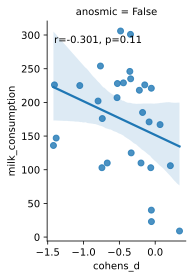

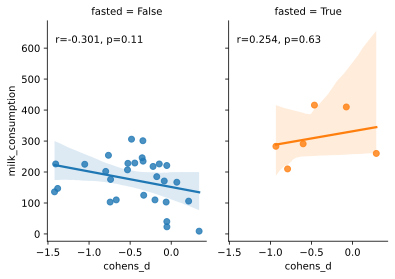

In [19]:
df_estimate_concat

import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['cohens_d'], data['milk_consumption'])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.3f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

data = df_estimate_concat[df_estimate_concat['fasted'] == False]
g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='anosmic',height=4,aspect=0.7,hue='anosmic')
g.map_dataframe(annotate)
plt.show()

data = df_estimate_concat[df_estimate_concat['anosmic'] == False]
g = sns.lmplot(data=data,x='cohens_d',y='milk_consumption',col='fasted',height=4,aspect=0.7,hue='fasted')
g.map_dataframe(annotate)
plt.show()

# plt.ylim(ymin=-50,ymax=500)

In [ ]:
plt.plot(PETH_slow_milk.mean(axis=(0,1)),label='slow')
# plt.plot(PETH_slow_water.mean(axis=(0,1)))
plt.plot(PETH_binge_on.mean(axis=(0,1)),label='binge')
# plt.plot(PETH_binge_off.mean(axis=(0,1)))
plt.xlim(xmin=40)
plt.legend()
plt.axvline(x=50,ls=':')
# plt.ylim(ymin=-0.15)

In [ ]:
baseline_window = 1
threshold_sd = 3.5
auroc = cal_auroc(PETH_slow_milk[:], baseline_window=baseline_window)
idx_positive = cell_class(auroc,window=2,threshold_sd=threshold_sd)
print(f'-- {round(len(idx_positive)/auroc.shape[0]*100,2)}%')

In [ ]:
t_scale = np.arange(-5,5,0.1)
plt.plot(t_scale,PETH_slow_milk[idx_positive].mean(axis=(0,1)),c=my_color_map[0],alpha=0.5)
# plt.plot(PETH_slow_water.mean(axis=(0,1)))
plt.plot(t_scale,PETH_binge_on[idx_positive].mean(axis=(0,1)),c=my_color_map[0])
# plt.plot(PETH_binge_off.mean(axis=(0,1)))
plt.xlim(xmin=-1)
plt.axvline(x=0,ls=':',c='k')

In [ ]:
baseline_window = 1
threshold_sd = 3.5
auroc_binge = cal_auroc(PETH_binge_on[:], baseline_window=baseline_window)
idx_positive_binge = cell_class(auroc_binge,window=2,threshold_sd=threshold_sd)
print(f'-- {round(len(idx_positive_binge)/auroc_binge.shape[0]*100,2)}%')


In [ ]:
plt.plot(PETH_slow_milk[idx_positive_binge].mean(axis=(0,1)),c=my_color_map[1],alpha=0.5)
plt.plot(PETH_binge_on[idx_positive_binge].mean(axis=(0,1)),c=my_color_map[1])
plt.plot(PETH_slow_milk[idx_positive].mean(axis=(0,1)),c=my_color_map[0],alpha=0.5)
plt.plot(PETH_binge_on[idx_positive].mean(axis=(0,1)),c=my_color_map[0])
plt.xlim(xmin=40)
# plt.ylim(ymin=-0.2)
plt.axvline(x=50,ls=':')

In [ ]:
isort = np.argsort(-auroc_binge[:,50:70].mean(axis=1))
isort = np.argsort(-auroc[:,50:70].mean(axis=1))
plt.imshow(auroc[isort,:],aspect='auto',vmin=0.2,vmax=0.8,cmap='bwr')
plt.show()
plt.imshow(auroc_binge[isort,:],aspect='auto',vmin=0.2,vmax=0.8,cmap='bwr')

In [ ]:
# plt.imshow(PETH_concat,aspect='auto')

In [ ]:
### try a quick PCA here?

# PSTH_milk_concat
PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_binge_on[:,:,40:].mean(axis=1)],axis=1)
# PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_slow_water[:,:,40:].mean(axis=1),PETH_binge_on[:,:,40:].mean(axis=1)],axis=1)
# PETH_concat = np.concatenate([PETH_slow_milk[:,:,40:].mean(axis=1),PETH_slow_water[:,:,40:].mean(axis=1)],axis=1)

PETH_concat.shape

## PCA
from sklearn.decomposition import PCA

S = PETH_concat.copy()
# S = auROC_concat.copy()

model = PCA(n_components=np.min(S.shape))
# model = PCA(n_components=20)

model.fit(S)

# plot some components
X = model.components_
Y = model.transform(X)
plt.figure(figsize=(6, 4))
# plt.subplot(1, 2, 1)
for j in range(5):
    plt.plot(X[j] - j * 0.1, linestyle="-", linewidth=1, marker="",label=j)
plt.legend()
# plt.subplot(1, 2, 2)
# for j in range(5):
#     plt.plot(X[j, 10:40] - j * 0.05, linestyle="-", linewidth=1, marker="")
plt.tight_layout()
# plt.savefig('/Users/hunglo/Desktop/Lab_seminar_figs/PCA_PC5.png',dpi=600)
plt.show()

# loadings = model.components_.T * np.sqrt(model.explained_variance_)

# loading_matrix = pd.DataFrame(loadings)
# loading_matrix

In [ ]:


# pc_values = pc_df['PC1'][isort].values
# plt.plot(PETH_slow_milk[isort,:,:][pc_values>0.8].mean(axis=(0,1)))
# plt.plot(PETH_binge_on[isort,:,:][pc_values>0.8].mean(axis=(0,1)))
# plt.xlim(xmin=40)
# plt.axvline(x=50,ls=":")

In [ ]:
# i=0
# isort = np.argsort(-pc_df[f'PC{i+1}'].values)
# pc_values = pc_df[f'PC{i+1}'][isort].values
# for j in range(30):
#     plt.plot(PETH_binge_on[isort][j].mean(axis=0)-j)
# plt.show()
# for j in range(30):
#     plt.plot(PETH_slow_milk[isort][j].mean(axis=0)-j)
# plt.show()

In [ ]:
## Plot cell weights against PCs.
pc_df = pd.DataFrame()
for i in range(50):
    pc_df[i] = S @ model.components_[i]
    pc_df[i] = pc_df[i]/np.max(np.abs(pc_df[i]))  # Normalize or not
pc_df

col_names = [f'PC{i+1}' for i in range(pc_df.shape[1])]
col_dict = {}
for i in range(pc_df.shape[1]):
    col_dict[i]=col_names[i]

pc_df.rename(columns=col_dict,inplace=True)

weight_threshold = 0.2

for i in range(5):
    isort = np.argsort(-pc_df[f'PC{i+1}'].values)
    pc_values = pc_df[f'PC{i+1}'][isort].values
    plt.plot(PETH_slow_milk[isort,:,:][pc_values>weight_threshold].mean(axis=(0,1)),label='slow milk')
    plt.plot(PETH_binge_on[isort,:,:][pc_values>weight_threshold].mean(axis=(0,1)),label='binge milk')
    plt.legend(title=f'n={sum(pc_values>weight_threshold)}')
    plt.xlim(xmin=40)
    plt.title(f'PC{i+1} top coefficient cells')
    plt.axvline(x=50,ls=":")
    sns.despine()
    plt.show()

# isort = np.argsort(-pc_df['PC2'].values)
# # plt.plot(pc_df.iloc[isort]['PC1'].values)

# plt.imshow(pc_df.iloc[isort,0:5][0:],aspect='auto',interpolation='None')
# plt.colorbar()


In [ ]:
for i in range(5):
    plt.plot(X[i][:60],label='slow milk',c=my_color_map[i],alpha=0.5,lw=2)
    # plt.plot(X[i][60:120],label='slow water',c=my_color_map[1],alpha=0.5,lw=2)
    plt.plot(X[i][60:],label='binge',c=my_color_map[i],alpha=1,lw=2)
    plt.legend()
    plt.title(f'PC{i+1}')
    plt.axvline(x=10,ls=':')
    sns.despine()
    plt.show()


In [ ]:
#@title Variance explained
## Scree plot

cum_vx = np.cumsum(model.explained_variance_ratio_)
num_pc_90 = len(cum_vx[cum_vx<0.9])+1

fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
ax0.plot(
    np.arange(len(model.explained_variance_ratio_)) + 1,
    model.explained_variance_ratio_,
    linewidth=2,
)
ax0.set_title("Scree plot", fontsize=16)
ax0.set_xlabel("PC number", fontsize=14)
ax0.set_ylabel("Variance explained", fontsize=14)
# ax0.vlines(ymin=0, ymax=np.max(model.explained_variance_ratio_), x=num_pc_90, linestyles=":", linewidth=2)
ax0.axvline(x=num_pc_90, linestyle=":", linewidth=2,label=f"90% explained\nwith top {num_pc_90} PCs")
ax0.legend(loc=1,frameon=False)

ax1.plot(
    np.arange(len(model.explained_variance_ratio_)) + 1,
    np.cumsum(model.explained_variance_ratio_),
    linewidth=2,
)
ax1.set_title("Scree plot (cum.)", fontsize=16)
ax1.set_xlabel("PC number", fontsize=14)
# ax1.set_ylabel("Variance explained", fontsize=14)
# ax1.vlines(ymin=np.max(model.explained_variance_ratio_), ymax=1, x=num_pc_90, linestyles=":", linewidth=2,label='90% explained')
ax1.axvline(x=num_pc_90, linestyle=":", linewidth=2,label=f"90% explained\nwith top {num_pc_90} PCs")

ax1.legend(loc=4,frameon=False)
sns.despine()

plt.tight_layout()
plt.show()

print(
    "Variance explained when PC="+str(num_pc_90)+": \n"
    + str(np.cumsum(model.explained_variance_ratio_)[num_pc_90-1])
)

In [ ]:
plt.plot(X[0][:60],X[1][:60],label='slow')
plt.plot(X[0][60:],X[1][60:],label='binge')
plt.legend()

In [ ]:
### SVM just for fun

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import roc_auc_score
## new classifier with pipeline w/ scaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
## function for classifer
def svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=False,repeat=100):
    # initiate score list
    score_svm_avg_100 = []
    auroc_svm_avg_100 = []
    score_rfc_avg_100 = []

    for j in range(repeat):
        trial_num = PETH_binge_on.shape[1]
        # trial_num = PETH_slow_milk.shape[1]
        # trial_num = 10
        picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

        # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
        ## auc
        milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,50:80], dx=0.1).T)
        # milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
        milk_max['Binge'] = 0
        binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,50:80], dx=0.1).T)
        # binge_max = pd.DataFrame(PETH_binge_on[:,:,50:80].mean(axis=2).T)
        binge_max['Binge'] = 1

        design_matrix = pd.concat([milk_max,binge_max])
        design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
        if shuffle:
            design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

        ## SVM & RFC
        # Set x & y
        X = design_matrix.iloc[:,:-1]
        y = design_matrix.iloc[:,-1]

        # CV
        cv = StratifiedKFold(n_splits=fold)
        svc = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
        rfc = make_pipeline(StandardScaler(), RandomForestClassifier())

        score_svm = []
        auc_svm = []
        score_rfc = []
        auc_rfc = []

        # for i,(train, test) in enumerate(loo.split(X)):

        for i, (train, test) in enumerate(cv.split(X, y)):
            svc.fit(X.iloc[train], y.iloc[train])
            rfc.fit(X.iloc[train], y.iloc[train])
            y_score = svc.predict(X.iloc[test])

            score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
            auc_svm.append(roc_auc_score(y.iloc[test],y_score))
            score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

        score_svm_avg_100.append(np.mean(score_svm))
        auroc_svm_avg_100.append(np.mean(auc_svm))
        score_rfc_avg_100.append(np.mean(score_rfc))
        if j % 10 ==0:
            print(f'Trial {j}')
        # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))

    return score_svm_avg_100,score_rfc_avg_100,auroc_svm_avg_100

def svm_rfc_plot(score_svm_avg_100,score_rfc_avg_100):
    plt.figure(figsize=[3,4])
    df_temp = pd.DataFrame([])
    df_temp['svm'] = score_svm_avg_100
    df_temp['rfc'] = score_rfc_avg_100
    df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

    sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
    sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
    # sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
    plt.legend([],[], frameon=False)
    plt.text(0,np.mean(score_svm_avg_100),round(np.mean(score_svm_avg_100),2),ha='left',va='bottom')
    plt.text(1,np.mean(score_rfc_avg_100),round(np.mean(score_rfc_avg_100),2),ha='left',va='bottom')
    plt.axhline(y=0.5,ls=':',c='k')
    sns.despine()
    plt.tight_layout()
    plt.show()


score_svm_avg_100,score_rfc_avg_100,auroc_svm_avg_100 = svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=False,repeat=100)
# score_svm_avg_100_sh,score_rfc_avg_100_sh,auroc_svm_avg_100_sh = svm_rfc(PETH_slow_milk,PETH_binge_on,fold=2,shuffle=True,repeat=100)

svm_rfc_plot(score_svm_avg_100,score_rfc_avg_100)
# svm_rfc_plot(score_svm_avg_100_sh,score_rfc_avg_100_sh)


In [ ]:
# initiate score list
score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    trial_num = PETH_binge_on.shape[1]
    # trial_num = PETH_slow_milk.shape[1]
    # trial_num = 10
    picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

    # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
    ## auc
    milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,50:80], dx=0.1).T)
    # milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
    milk_max['Binge'] = 0
    binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,50:80], dx=0.1).T)
    # binge_max = pd.DataFrame(PETH_binge_on[:,:,50:80].mean(axis=2).T)
    binge_max['Binge'] = 1

    design_matrix = pd.concat([milk_max,binge_max])
    design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
    # design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

    ## SVM & RFC
    # Set x & y
    X = design_matrix.iloc[:,:-1]
    y = design_matrix.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=int(X.shape[0]/2))
    # cv = StratifiedShuffleSplit(n_splits=2)
    # loo = LeaveOneOut()
    # svc = svm.SVC(kernel='linear', probability=True)
    svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    rfc = make_pipeline(StandardScaler(), RandomForestClassifier())
    # rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # for i,(train, test) in enumerate(loo.split(X)):

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))
    if j % 10 ==0:
        print(f'Trial {j}')
    # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
# plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)],color='grey')
# plt.plot(np.zeros(len(score_svm_avg_100)),score_svm_avg_100,marker='.',ls='',c='k')
# plt.plot(np.ones(len(score_rfc_avg_100)),score_rfc_avg_100,marker='.',ls='',c='k')
df_temp = pd.DataFrame([])
df_temp['svm'] = score_svm_avg_100
df_temp['rfc'] = score_rfc_avg_100
df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

# sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
# sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
plt.legend([],[], frameon=False)
plt.text(0,np.mean(score_svm_avg_100)+0.05,round(np.mean(score_svm_avg_100),2),ha='center')
plt.text(1,np.mean(score_rfc_avg_100)+0.05,round(np.mean(score_rfc_avg_100),2),ha='center')
plt.axhline(y=0.5,ls=':',c='k')
sns.despine()
plt.tight_layout()
print(round(np.mean(score_svm_avg_100),2), round(np.mean(score_rfc_avg_100),2))

In [ ]:
## transform array to pd dataframe
slow vs binge in GC

0.43 / 0.33 (match trials, max in 2 sec)
0.37 / 0.33 (match trials, max in 3 sec)

0.47 / 0.33 (match trials, mean in 2 sec)
0.47 / 0.33 (match trials, mean in 3 sec)

0.34 / 0.34 (match trials, mean in 2 sec before stim)

## auc
0.44 / 0.33 (match trials, auc, dx=0.1 in 2 sec)
0.45 / 0.33 (match trials, auc, dx=0.1 in 3 sec)

slow vs binge in aPC
0.51 / 0.59 (match trials, auc, dx=0.1 in 3 sec)
0.53 / 0.57 (match trials, auc, dx=0.1 in 2 sec)
0.52 / 0.58 (match trials, auc, dx=0.1 in 1-3 sec)

0.52 / 0.57 (match trials, mean in 3 sec)

0.76 / 0.84

In [ ]:
## slow milk vs water
# initiate score list
score_svm_avg_100 = []
score_rfc_avg_100 = []

for j in range(100):
    trial_num = PETH_slow_water.shape[1]
    # trial_num = PETH_slow_milk.shape[1]
    # trial_num = 10
    picked = sorted(np.random.choice(PETH_slow_milk.shape[1],trial_num,replace=False))

    # sorted(np.random.choice(b_lick_p1_flatten,len(s_lick_p1_flatten),replace=False))
    ## auc
    # milk_max  = pd.DataFrame(np.trapz(PETH_slow_milk[:,picked,60:80], dx=0.1).T)
    milk_max  = pd.DataFrame(PETH_slow_milk[:,picked,50:80].mean(axis=2).T)
    # milk_max['Binge'] = 0
    milk_max['milk']  = 1
    # binge_max  = pd.DataFrame(np.trapz(PETH_binge_on[:,:,60:80], dx=0.1).T)
    binge_max = pd.DataFrame(PETH_slow_water[:,:,50:80].mean(axis=2).T)
    # binge_max['Binge'] = 1
    binge_max['milk'] = 0

    design_matrix = pd.concat([milk_max,binge_max])
    design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
    # design_matrix['Binge'] = design_matrix['Binge'].sample(frac=1).reset_index(drop=True) ## shuffling for controls

    ## SVM & RFC
    # Set x & y
    X = design_matrix.iloc[:,:-1]
    y = design_matrix.iloc[:,-1]

    # CV
    cv = StratifiedKFold(n_splits=int(X.shape[0]/2))
    # cv = StratifiedShuffleSplit(n_splits=2)
    # loo = LeaveOneOut()
    svc = svm.SVC(kernel='linear', probability=True)
    rfc = RandomForestClassifier()

    score_svm = []
    auc_svm = []
    score_rfc = []
    auc_rfc = []

    # for i,(train, test) in enumerate(loo.split(X)):

    for i, (train, test) in enumerate(cv.split(X, y)):
        svc.fit(X.iloc[train], y.iloc[train])
        rfc.fit(X.iloc[train], y.iloc[train])

        score_svm.append(svc.score(X.iloc[test], y.iloc[test]))
        score_rfc.append(rfc.score(X.iloc[test], y.iloc[test]))

    score_svm_avg_100.append(np.mean(score_svm))
    score_rfc_avg_100.append(np.mean(score_rfc))
    if j % 10 ==0:
        print(f'Trial {j}')
    # print('Trial:',j+1, '\n',np.mean(score_svm),'\n', np.mean(score_rfc))
plt.figure(figsize=[3,4])
# plt.bar(['svm','rfc'],[np.mean(score_svm_avg_100),np.mean(score_rfc_avg_100)],color='grey')
# plt.plot(np.zeros(len(score_svm_avg_100)),score_svm_avg_100,marker='.',ls='',c='k')
# plt.plot(np.ones(len(score_rfc_avg_100)),score_rfc_avg_100,marker='.',ls='',c='k')
df_temp = pd.DataFrame([])
df_temp['svm'] = score_svm_avg_100
df_temp['rfc'] = score_rfc_avg_100
df_temp = df_temp.melt(var_name='classifier',value_name='accuracy')

sns.stripplot(data=df_temp,x='classifier',y='accuracy',hue='classifier',dodge=0.25,alpha=0.4)
sns.pointplot(data=df_temp,x='classifier',y='accuracy',markers="d",errorbar='sd',join=False,hue='classifier')
# sns.swarmplot(pd.DataFrame(np.hstack([score_svm_avg_100,score_rfc_avg_100])))
plt.legend([],[], frameon=False)
plt.text(0,np.mean(score_svm_avg_100)+0.05,round(np.mean(score_svm_avg_100),2),ha='center')
plt.text(1,np.mean(score_rfc_avg_100)+0.05,round(np.mean(score_rfc_avg_100),2),ha='center')
plt.axhline(y=0.5,ls=':',c='k')
sns.despine()
plt.tight_layout()
print(round(np.mean(score_svm_avg_100),2), round(np.mean(score_rfc_avg_100),2))

In [ ]:

## make a condition here to check if we have the corresponding Ca2+
df_accepted, df_z = binge.loadandsync_incopix_csv(file_path)




In [ ]:
## get neural matrix for further processing

def norm_ca(df):
    df_norm = pd.DataFrame([])
    for idx,cell in enumerate(df.columns):
        ## normalize to 0-1
        df_max=np.max(df[cell])
        df_min=np.min(df[cell])
        df_norm[cell] = (df[cell]-df_min)/(df_max-df_min)
    return df_norm

def ca2_plot(df,scale=5,cell_idx=None):
    ## scale here is just to help viz
    if cell_idx == None:
        for idx,cell in enumerate(df.columns):
            plt.plot(df[cell]*scale+idx,lw=1)
    else:
        for idx,cell_ in enumerate(list(cell_idx)):
            ## normalize to 0-1
            cell = df.columns[idx]
            plt.plot(df[cell]*scale+idx,lw=1)


def detect_binge_bout(Pump1,interval=3):
    # if pump interval is less than 2 seconds?
    Pump1 = np.pad(Pump1, (2, 2), 'constant', constant_values=(0,0))
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[idx_+1])
        end_concat.append(Pump1[idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending
    binge_epoch = nap.IntervalSet(start_concat,end_concat)
    return binge_epoch


## downsample Ca2+ data to 10 Hz all together for easier processing afterward?
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num],columns=df_accepted.columns)
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted


def get_PETH_dict(df_accepted,slow_milk_ts_clean,slow_water_ts_clean):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_milk = {} 
    PETH_trace_water = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([len(slow_milk_ts_clean),num_bins])
        for trial, time in enumerate(slow_milk_ts_clean):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_milk[cell] = PETH_trace
        PETH_trace = np.zeros([len(slow_water_ts_clean),num_bins])
        for trial, time in enumerate(slow_water_ts_clean):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_water[cell] = PETH_trace
    return PETH_trace_milk, PETH_trace_water


def get_PETH_binge(df_accepted,binge_epoch):
    ## now generate PSTH for each cell
    windowsize = 10 # sec, before + after
    half_window = int(windowsize/2)
    num_bins = windowsize * 10 # based on 10 Hz
    # t_scale = np.linspace(-5,5,num_bins)
    PETH_trace_binge_on = {} 
    PETH_trace_binge_off = {}

    cellset = df_accepted.columns

    for cell in cellset:
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['start']):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_binge_on[cell] = PETH_trace
        PETH_trace = np.zeros([binge_epoch.shape[0],num_bins])
        for trial, time in enumerate(binge_epoch['end']):
            PETH_trace[trial,:] = df_accepted[cell][time-half_window:time+half_window].reset_index(drop=True)[0:num_bins]
            PETH_trace_binge_off[cell] = PETH_trace
    return PETH_trace_binge_on,PETH_trace_binge_off

## align baseline to 0
def baseline_correct(PETH):
    for key in PETH.keys():
        matrix = PETH.get(key)
        for trial in range(matrix.shape[0]):
            matrix[trial,:] -= np.mean(matrix[trial,40:50]) # baseline mean centered (1 sec before event time)
        PETH[key] = matrix
    return PETH

interval = 3
binge_epoch = detect_binge_bout(PAll,interval=interval)
# now get remaining period as non binge period
not_binge_epoch = nap.IntervalSet(0,PAll[-1]+50).set_diff(binge_epoch)
not_binge_epoch['start'] = not_binge_epoch['start']+0.2 # to exclude boundary events
not_binge_epoch['end']   = not_binge_epoch['end']-0.2   # to exclude boundary events

slow_milk_ts  = nap.Ts(P1).restrict(not_binge_epoch).index # get all other events as slow
slow_water_ts = nap.Ts(P2).restrict(not_binge_epoch).index

# check there is licking after the delivery in 2 sec
slow_milk_ts_clean  = np.array([t for t in slow_milk_ts  if (L1[L1>t][0]-t) <2])
slow_water_ts_clean = np.array([t for t in slow_water_ts if (L1[L1>t][0]-t) <2])

df_downsampled   = downsample(df_accepted)
df_downsampled_z = downsample(df_z)

# if there is no slow eating event
if len(slow_milk_ts_clean)==0:
    PETH_trace_milk = {}
elif len(slow_water_ts_clean)==0:
    PETH_trace_water = {}
else:
    PETH_trace_milk,PETH_trace_water = get_PETH_dict(df_downsampled,slow_milk_ts_clean,slow_water_ts_clean)
    PETH_trace_milk  = baseline_correct(PETH_trace_milk)
    PETH_trace_water = baseline_correct(PETH_trace_water)

if binge_epoch.shape[0] == 0:
    PETH_trace_binge_on,PETH_trace_binge_off = {},{}
else:
    PETH_trace_binge_on,PETH_trace_binge_off = get_PETH_binge(df_downsampled,binge_epoch)
    PETH_trace_binge_on  = baseline_correct(PETH_trace_binge_on)
    PETH_trace_binge_off = baseline_correct(PETH_trace_binge_off)


select_overview = df_overview[df_overview['Mouse ID'] == mouse_id].copy()
select_overview = select_overview[select_overview['Recording date']=='20'+date.replace(".", "/")]

Pump1_solution = select_overview['Flavor 1'].to_numpy()[0].lower()
Pump2_solution = select_overview['Flavor 2'].to_numpy()[0].lower()
Food_deprivation = select_overview['Food_deprived'].to_numpy()[0].lower()
if 'CaMK2a' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'CaMK2'
elif 'iSeroSnFR' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'iSeroSnFR'
elif 'dLight' in select_overview['Genotype'].to_numpy()[0]:
  Genotype = 'dLight'
elif 'S2GC' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'S2GC'
elif 'S2' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'S2'
elif 'GC' in select_overview['Genotype'].to_numpy()[0]:
    Genotype = 'GC'
else:
  Genotype = select_overview['Genotype'].to_numpy()[0]
mouse_name = select_overview['Mouse Name'].to_numpy()[0]

## initiate a dict for saving npy
dat = {}
dat['PETH_binge_on']   = PETH_trace_binge_on
dat['PETH_binge_off']  = PETH_trace_binge_off
dat['PETH_slow_milk']  = PETH_trace_milk
dat['PETH_slow_water'] = PETH_trace_water
dat['Binge_epoch']     = binge_epoch

dat['mouse_name']    = mouse_name
dat['mouse_id']      = mouse_id
dat['cell_type']     = Genotype
dat['date_exp']      = date.replace(".", "") # save with no dot, so it's YYMMDD
dat['pump_solution'] = (Pump1_solution, Pump2_solution)
dat['dt']            = 0.10 # second, exposure time of each frame
dat['food_deprivation_level'] = Food_deprivation

output_file_name = f'/Users/hunglo/Documents/inscopix_csv/processed_npy/{mouse_id}_{date}_{Genotype}_{Pump1_solution}_{Pump2_solution}_{Food_deprivation}.npy'
np.save(output_file_name, dat)
print(f'saved: {mouse_id} {date.replace(".", "")}')



## next steps:
## 1) condition if some of the feeding event is empty (no pump timestamps)
## 2) all this part in 1 function?
## 3) save output in npy format



In [ ]:
PETH_trace_binge_off.keys()

In [ ]:
for idx,key in enumerate(PETH_trace_binge_on.keys()):
    print(idx,key)
    plt.plot(PETH_trace_binge_on.get(key).mean(axis=0)+idx)
    # plt.plot(PETH_trace_binge_off.get(key).mean(axis=0)+idx)
    plt.plot(PETH_trace_milk.get(key).mean(axis=0)+idx)

In [ ]:
binge_epoch.shape

In [ ]:
df_accepted.shape

In [ ]:
df_accepted.iloc[:,0].plot()

In [ ]:
def downsample(df_accepted):
    ## add a condition here to check if it's already 10 hz
    from math import isclose
    a = df_accepted.index[1]-df_accepted.index[0] # get diff
    b = 0.05
    print(f'frame diff: {round(a,5)}')
    if isclose(a, b, abs_tol=1e-3):
        print('20 Hz -> 10 Hz')
        # if df_accepted.index[1]-df_accepted.index[0]
        from scipy import signal
        sample_num = int(df_accepted.shape[0]/2)
        df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num])
        return df_downsampled
    else:
        print('already 10 Hz')
        return df_accepted

df_downsampled = downsample(df_accepted)

In [ ]:
df_accepted
from scipy import signal
## new_idx
## new sample num
sample_num = int(df_accepted.shape[0]/2)
df_downsampled =  pd.DataFrame(signal.resample(df_accepted, sample_num),index=df_accepted.index[::2][0:sample_num])

df_accepted.iloc[:,1].plot()
df_downsampled.iloc[:,1].plot()
plt.xlim(-10,5)
plt.xlim(300,310)
plt.ylim(0,10)


In [ ]:
## ok now extract PETH with +/- 5 sec, just in case we need more baseline time




In [ ]:
## Now let's load GPIO csv files from inscoopix recording, and binarize them to match to phenosys data


def find_match_isx_GPIO_csv(file_path):
    mouse_id = file_path.split('_Inscopix-')[0].split('/')[-1]
    date     = file_path.split('_Inscopix-')[1].split('_')[0]
    date_nodot = date.replace(".", "")
    GPIO_folder = '/Users/hunglo/Documents/inscopix_csv/Ca2_csv/'
    subfolders = sorted([x[0] for x in os.walk(GPIO_folder)])
    subfolders = [f for f in subfolders if mouse_id in f][0]
    extension = 'csv'
    os.chdir(subfolders) # cd to mouse folder
    result = sorted(glob.glob('*.{}'.format(extension)))
    result = [r for r in result if date in r and 'GPIO' in r]
    print(result)

    

GPIO_folder = '/Users/hunglo/Documents/inscopix_csv/Ca2_csv/'
subfolders = sorted([x[0] for x in os.walk(GPIO_folder)])
# print(subfolders)
subfolders = [f for f in subfolders if mouse_id in f][0]
# print(subfolders)

date_nodot = date.replace(".", "")
extension = 'csv'
os.chdir(subfolders)
result = sorted(glob.glob('*.{}'.format(extension)))
result = [r for r in result if 'GPIO' in r]
# print(result)
# result = [r for r in result if 'BES0421' in r]
select_file = [r for r in result if (mouse_id in r) & (date_nodot in r)][0]
select_file
